In [ ]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_dir = "lung_image_sets"
feature_file = "features.pt"
label_file = "labels.pt"
checkpoint_file = "best_model.pth"

NameError: name 'torch' is not defined

In [ ]:

import torch.nn.functional as F
from torchvision.transforms.functional import normalize

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()
        score = output[:, class_idx]
        score.backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam

def apply_grad_cam(image, model, layer_name):
    model.eval()
    target_layer = dict([*model.named_modules()])[layer_name]
    grad_cam = GradCAM(model, target_layer)
    cam = grad_cam.generate(image.unsqueeze(0).to(device))
    return cam.squeeze().detach().cpu().numpy()


In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_grad_cam(image_tensor, cam, alpha=0.4):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    overlay = heatmap * alpha + image * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title("Grad-CAM Overlay")
    ax[1].axis("off")

    plt.show()


In [ ]:
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
cuda.empty_cache()


torch.backends.cudnn.benchmark = True  
if torch.cuda.is_available():
    torch.cuda.set_device(0) 

In [ ]:
def plot_gpu_memory():
    fig, ax = plt.subplots(figsize=(10, 6))
    mem_info = cuda.memory_stats(device=device)
    ax.barh(['Allocated', 'Cached', 'Free'], 
           [mem_info['allocated_bytes.all.current'], 
            mem_info['reserved_bytes.all.current'],
            cuda.mem_get_info()[0]])
    ax.set_xlabel('Memory (Bytes)')
    ax.set_title('GPU Memory Distribution')
    return fig

In [ ]:
def plot_training_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.savefig('training_loss.png')


def plot_accuracy(accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Over Time')
    plt.legend()
    plt.savefig('test_accuracy.png')

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet152(pretrained=True)
        self.model.fc = nn.Linear(2048, 512)

    def forward(self, x):
        return self.model(x)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = datasets.ImageFolder(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, num_workers=4, 
                      pin_memory=True, persistent_workers=True)

feature_extractor = FeatureExtractor().to(device).eval()

if os.path.exists(feature_file) and os.path.exists(label_file):
    features = torch.load(feature_file).to(device)
    labels = torch.load(label_file).to(device)
else:
    dataloader = DataLoader(dataset, batch_size=8, num_workers=4, pin_memory=True)
    features, labels = [], []

    with torch.no_grad():
        for images, label_batch in dataloader:
            images = images.to(device)
            feats = feature_extractor(images)
            features.append(feats)
            labels.append(label_batch.to(device))

    features = torch.cat(features).to(device)
    labels = torch.cat(labels).to(device)
    torch.save(features, feature_file)
    torch.save(labels, label_file)

C:\Users\aydhi\AppData\Local\Temp\ipykernel_11064\3083759173.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(feature_file).to(device)
C:\Users\aydh

In [ ]:
train_indices, test_indices = train_test_split(range(len(labels)), test_size=0.2, random_state=42)
train_features, test_features = features[train_indices], features[test_indices]
train_labels, test_labels = labels[train_indices], labels[test_indices]

In [ ]:
def create_knn_graph(features, k=5):
    features = features.to(device).contiguous()
    n = features.size(0)
    dists = torch.cdist(features, features)
    _, indices = torch.topk(dists, k+1, largest=False)
    edge_index = torch.stack([
        torch.repeat_interleave(torch.arange(n, device=device), k),
        indices[:,1:k+1].flatten()
    ])
    return edge_index.to(device)

In [ ]:
edge_index = create_knn_graph(train_features, k=5)
train_data = Data(x=train_features, y=train_labels, edge_index=edge_index)

test_edge_index = create_knn_graph(test_features, k=5)
test_data = Data(x=test_features, y=test_labels, edge_index=test_edge_index)

In [ ]:
class GATClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim*heads, hidden_dim, heads=heads)
        self.gat3 = GATConv(hidden_dim*heads, output_dim, heads=1)
        self.scaler = torch.cuda.amp.GradScaler()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        with torch.cuda.amp.autocast():
            x = F.elu(self.gat1(x, edge_index))
            x = F.elu(self.gat2(x, edge_index))
            x = self.gat3(x, edge_index)
        return x
    

In [ ]:
model = GATClassifier(512, 64, len(torch.unique(train_labels))).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()


C:\Users\aydhi\AppData\Local\Temp\ipykernel_11064\3577681453.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [ ]:
def train():
    model.train()
    optimizer.zero_grad(set_to_none=True)
    with torch.cuda.amp.autocast():
        out = model(train_data)
        loss = criterion(out, train_data.y.to(device))
    model.scaler.scale(loss).backward()
    model.scaler.step(optimizer)
    model.scaler.update()
    return loss.item()

# %%
def test(data):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        pred = logits.argmax(dim=1)
        acc = (pred == data.y.to(device)).sum().item() / data.y.size(0)
        return acc, pred

In [ ]:
# if __name__ == "__main__":
#     memory_log = []
#     for epoch in range(600):
#         loss = train()
#         acc, _ = test(test_data)
#         memory_log.append(cuda.memory_allocated())
#         if epoch % 50 == 0:
#             plot_gpu_memory().savefig(f'gpu_memory_{epoch}.png')
    
#     plt.figure(figsize=(12, 6))
#     plt.plot(memory_log)
#     plt.title('GPU Memory Allocation During Training')
#     plt.xlabel('Epoch')
#     plt.ylabel('Bytes Allocated')
#     plt.savefig('training_memory_profile.png')

: 

In [ ]:

def test(data):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        pred = logits.argmax(dim=1)
        acc = (pred == data.y).sum().item() / data.y.size(0)
        return acc, pred

In [ ]:
def plot_attention_heatmap(attn_weights):
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(attn_weights.cpu().numpy(), cmap='hot', interpolation='nearest')
    plt.colorbar(im)
    ax.set_title('Attention Weight Heatmap')
    ax.set_xlabel('Source Nodes')
    ax.set_ylabel('Target Nodes')
    return fig

In [ ]:
def plot_3d_feature_space(features, labels):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=3)
    embeddings = tsne.fit_transform(features.cpu().numpy())
    
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embeddings[:,0], embeddings[:,1], embeddings[:,2], 
                       c=labels.cpu().numpy(), cmap='viridis', depthshade=True)
    plt.colorbar(scatter)
    ax.set_title('3D t-SNE Feature Projection')
    return fig

C:\Users\aydhi\AppData\Local\Temp\ipykernel_11064\3577681453.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
C:\Users\aydhi\AppData\Local\Temp\ipykernel_11064\3499625486.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\aydhi\AppData\Local\Temp\ipykernel_11064\3577681453.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\aydhi\AppData\Local\Temp\ipykernel_11064\3499625486.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\aydhi\AppData\Local\Temp\ipykernel_11064\3577681453.py:11: FutureWarning: `torch

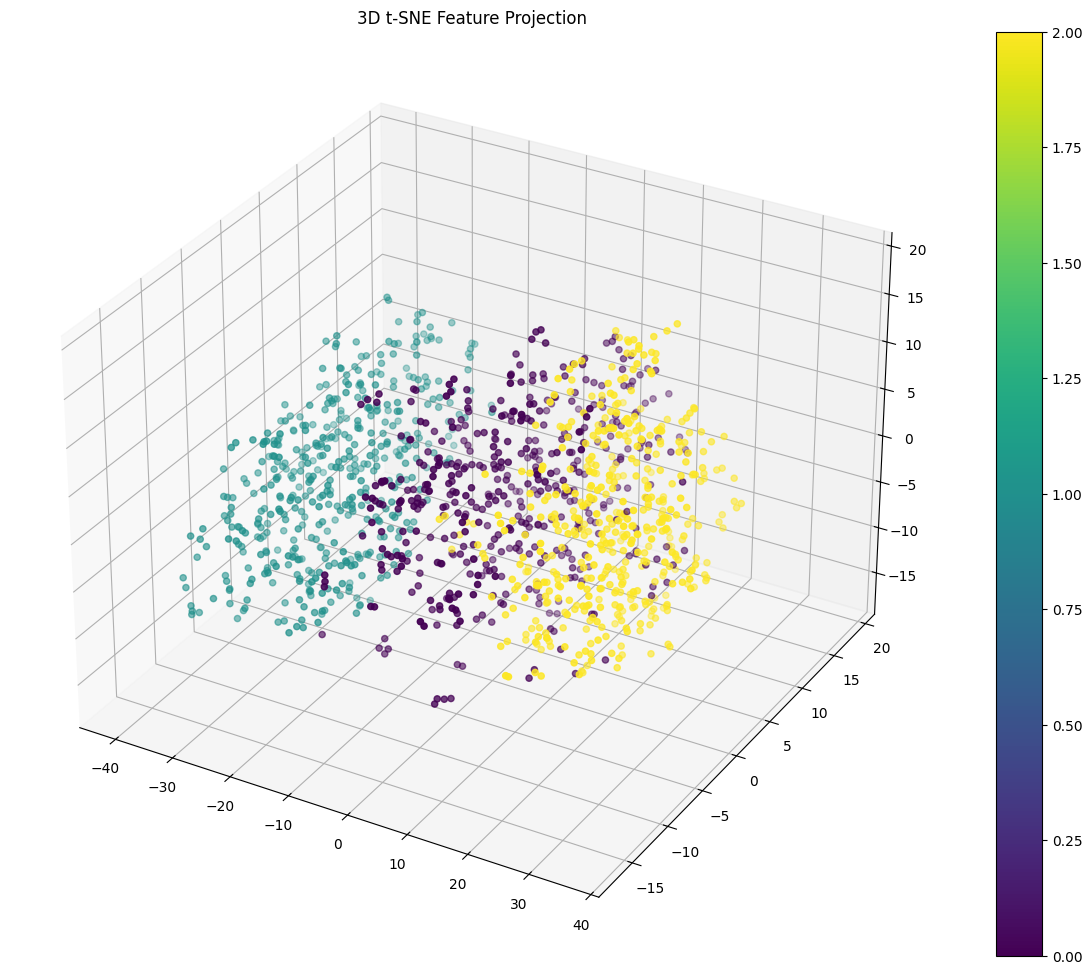

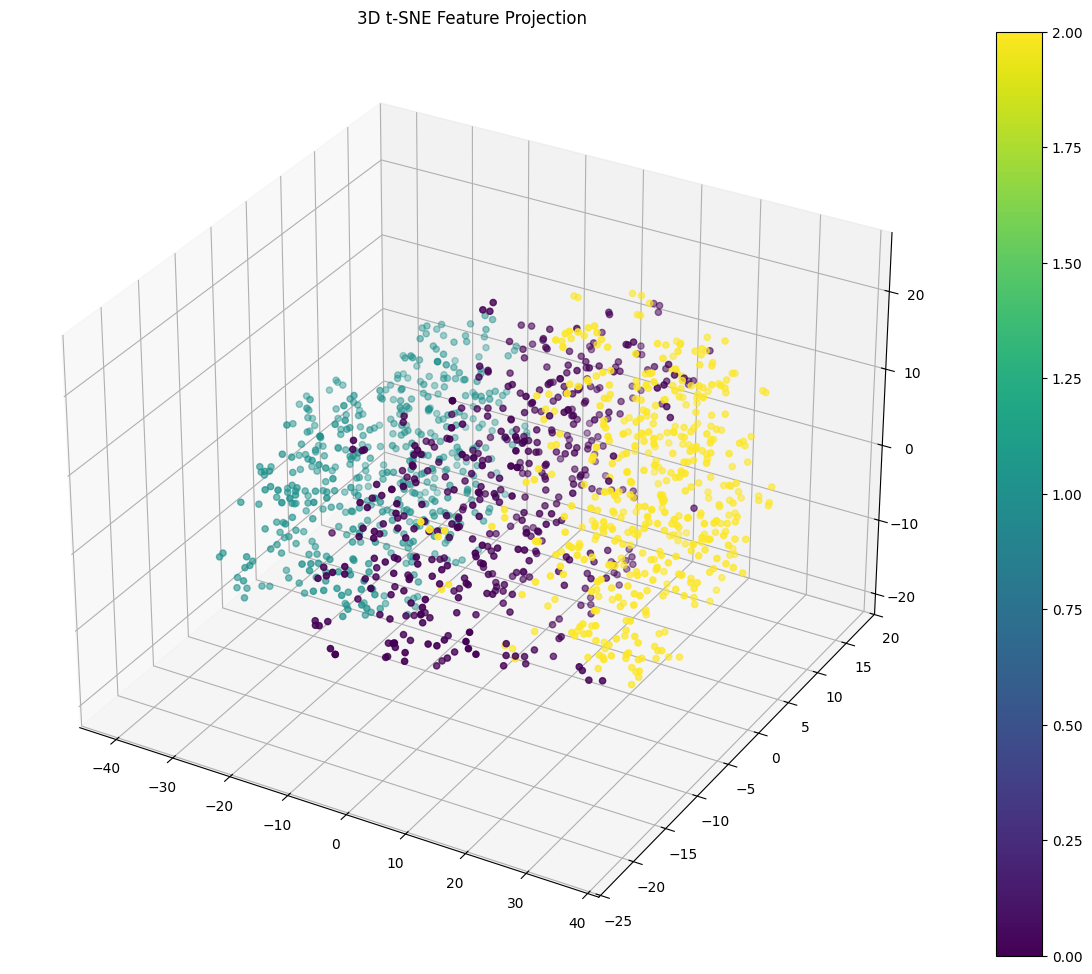

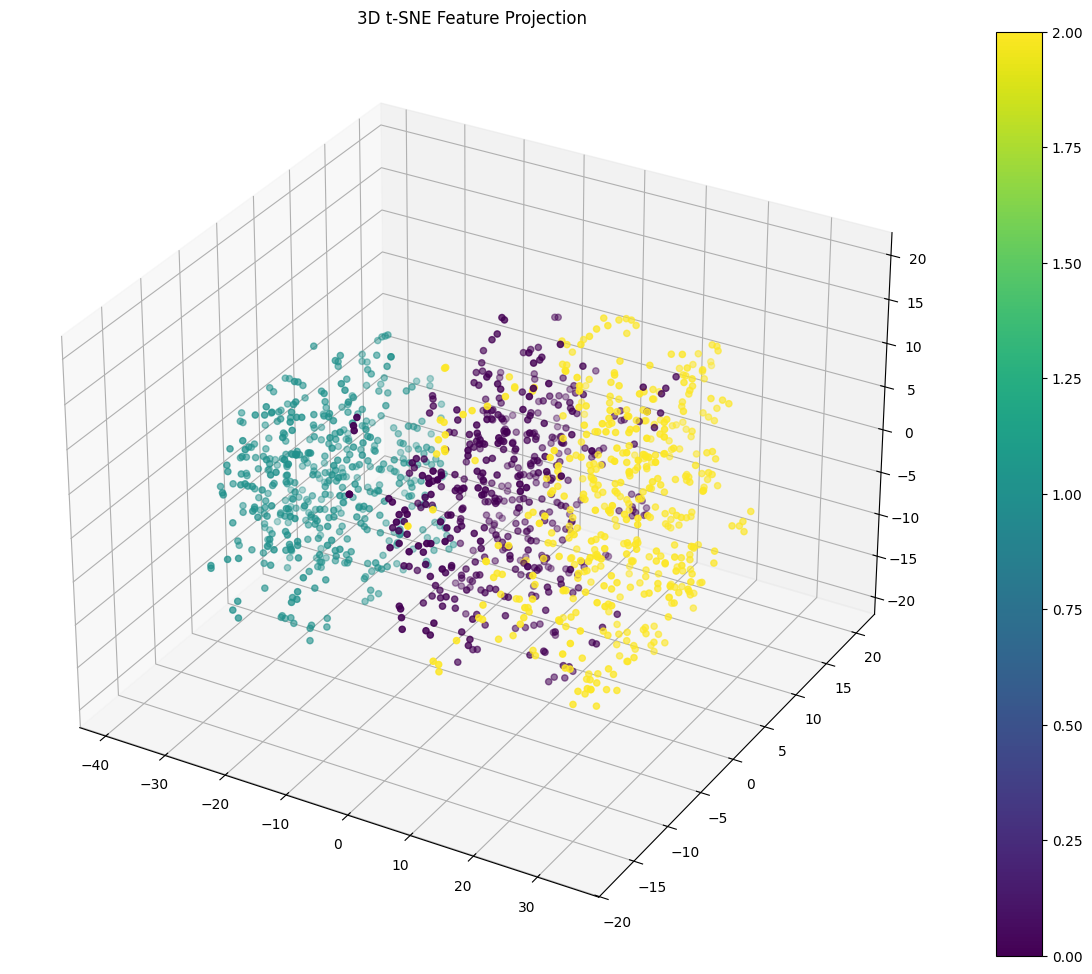

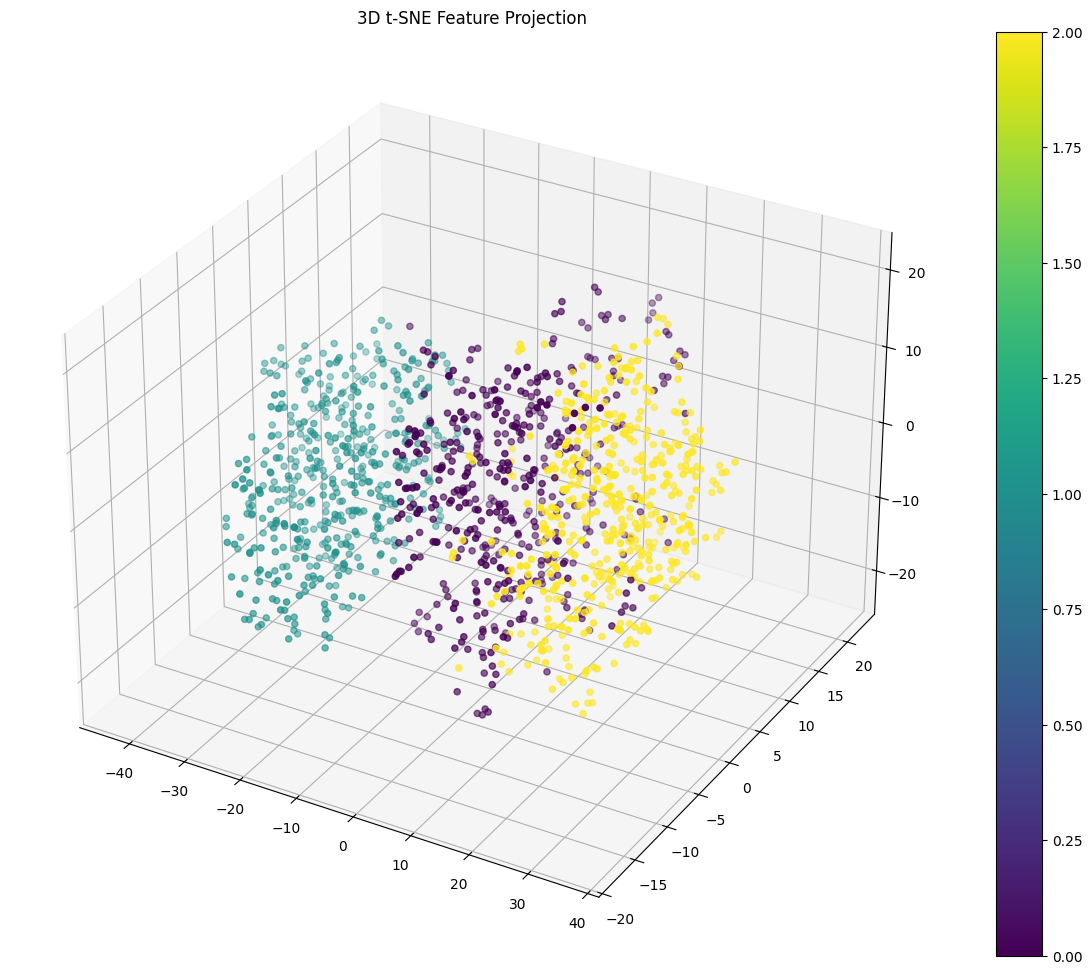

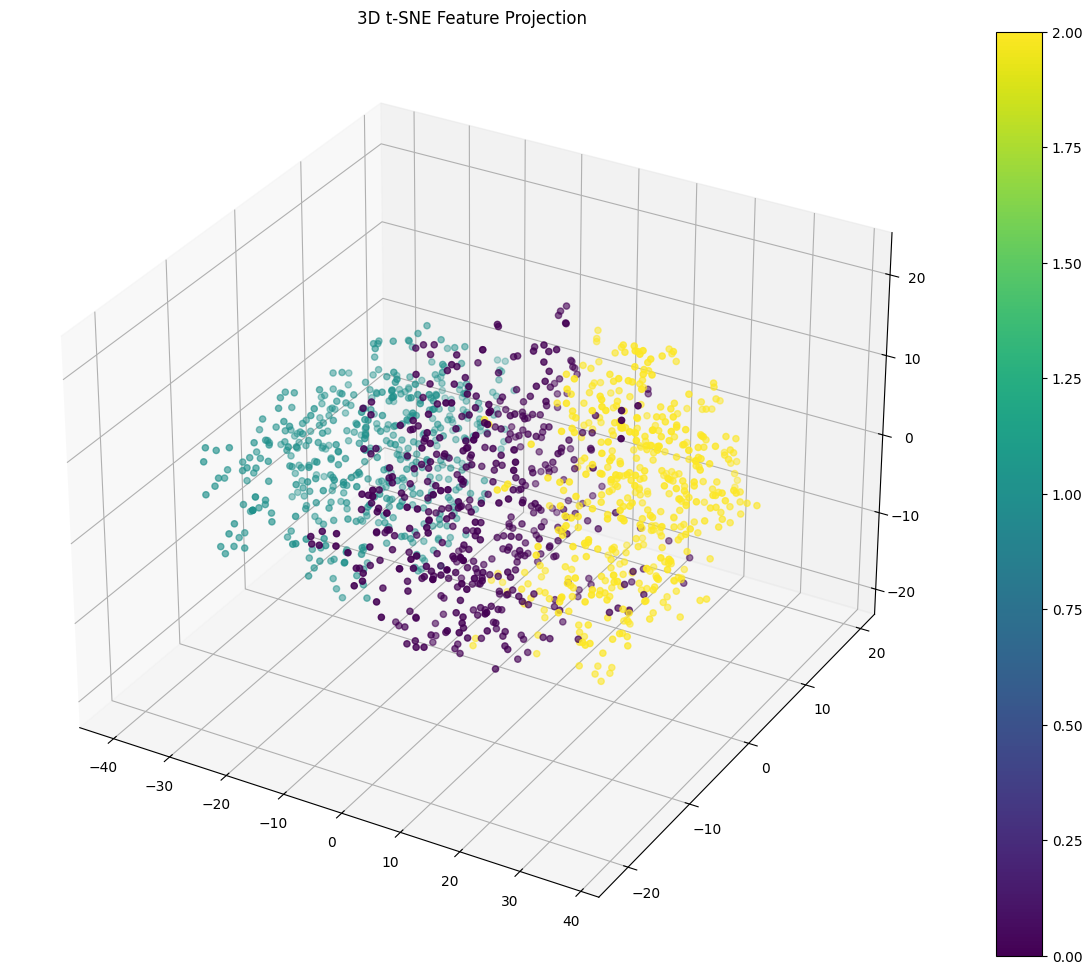

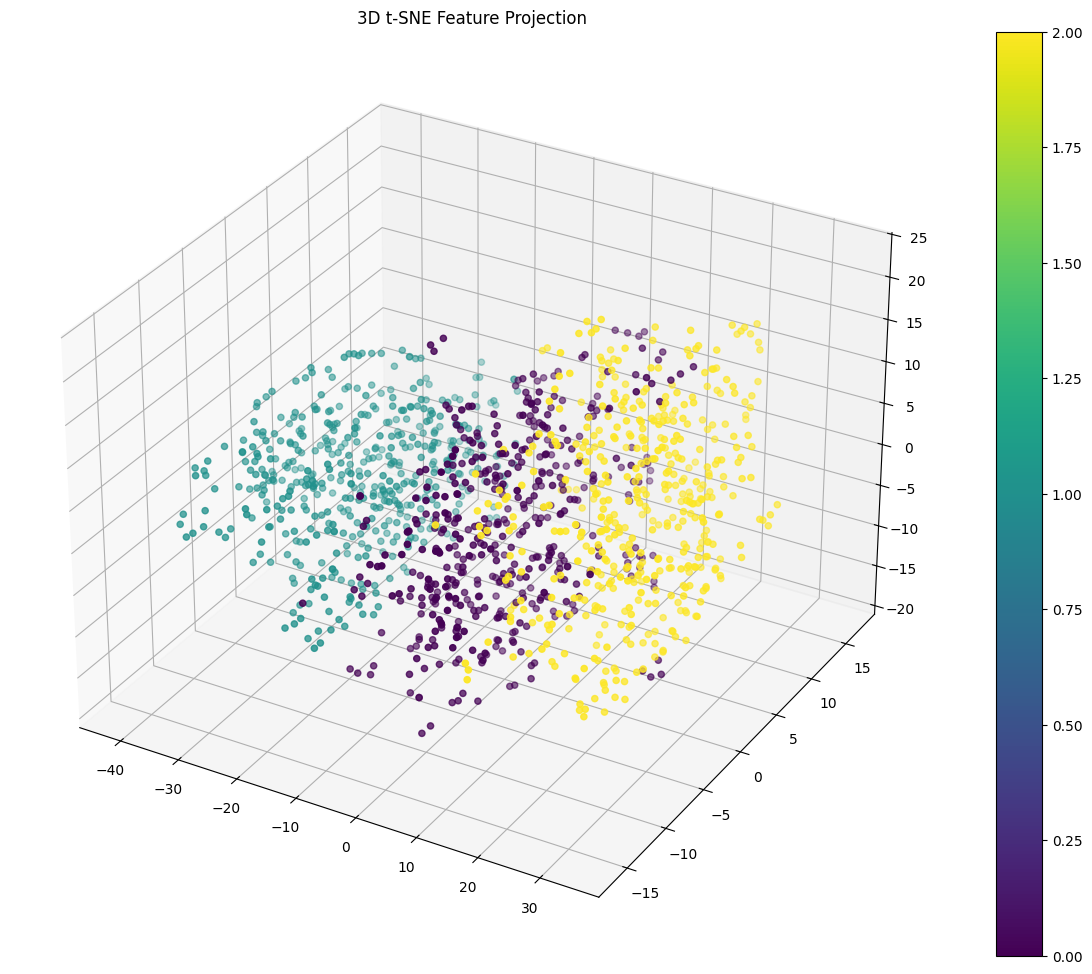

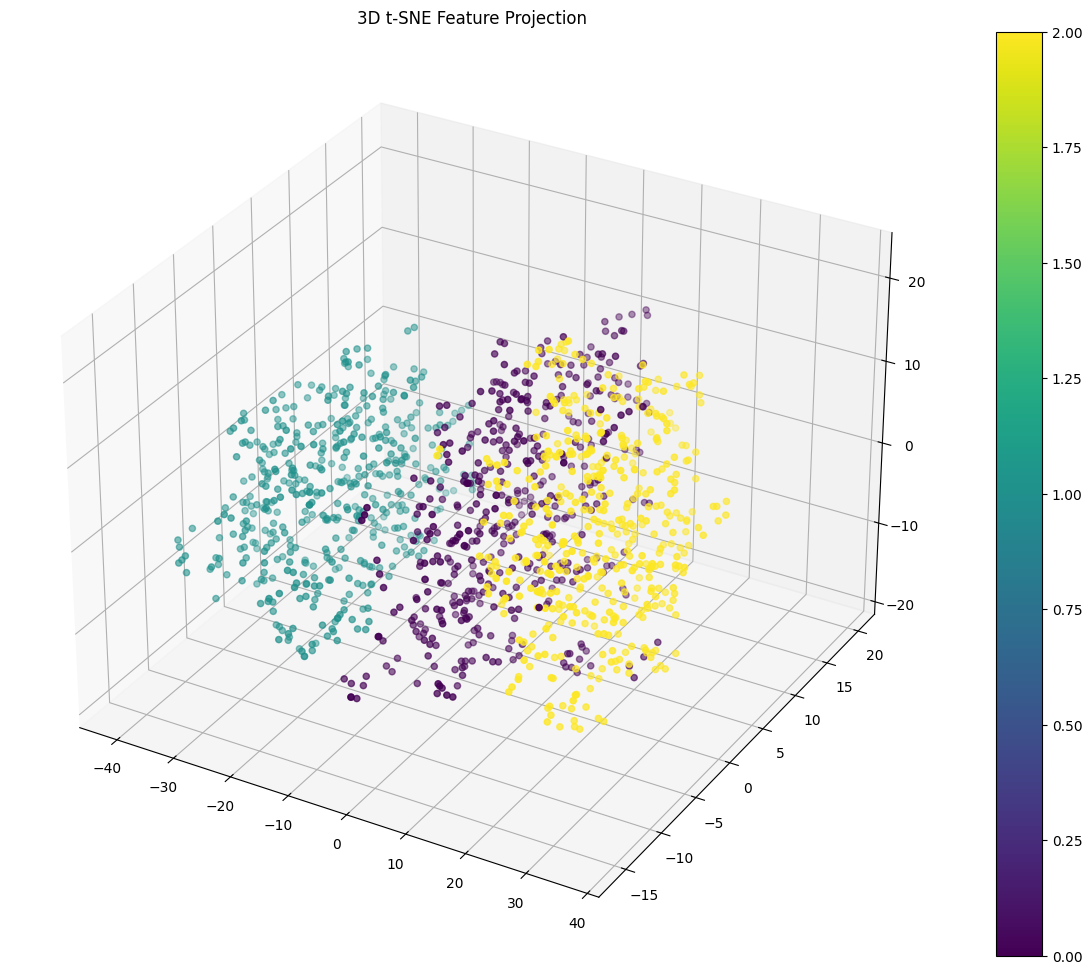

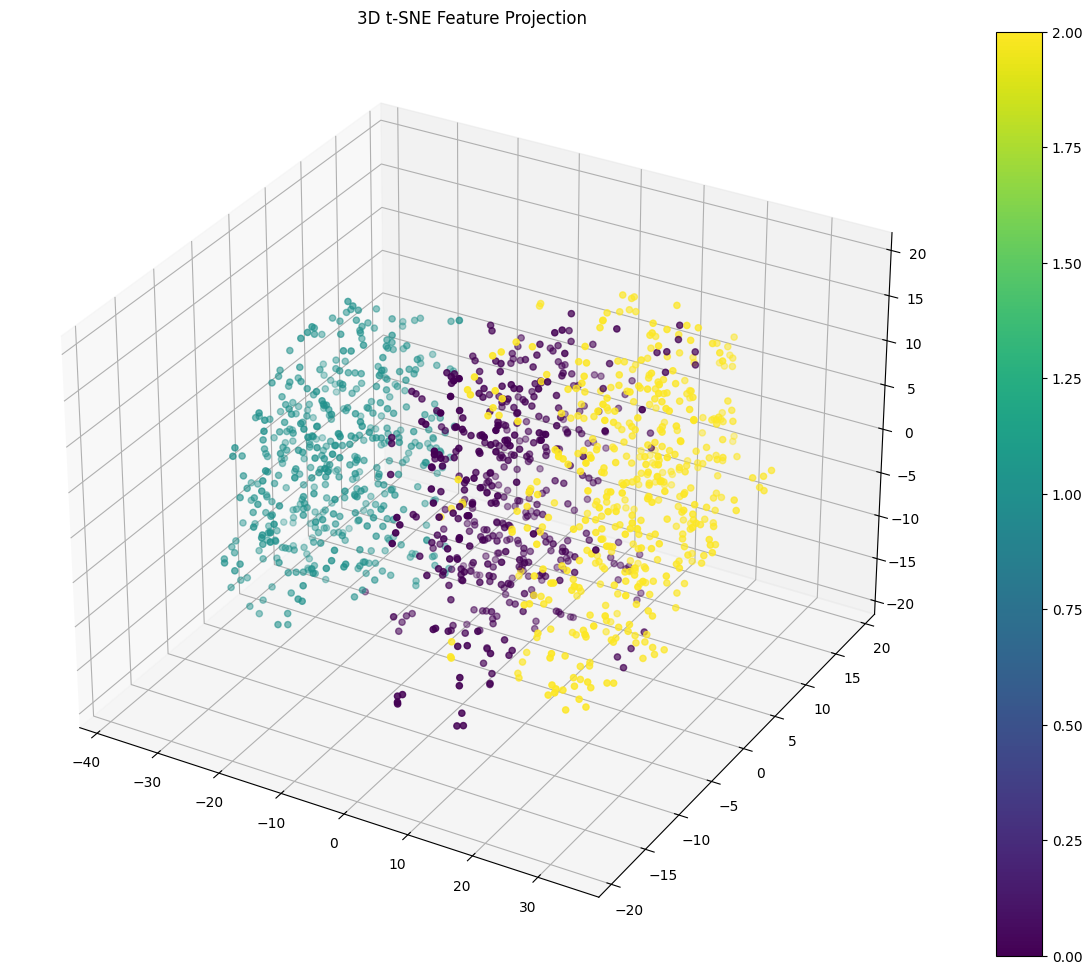

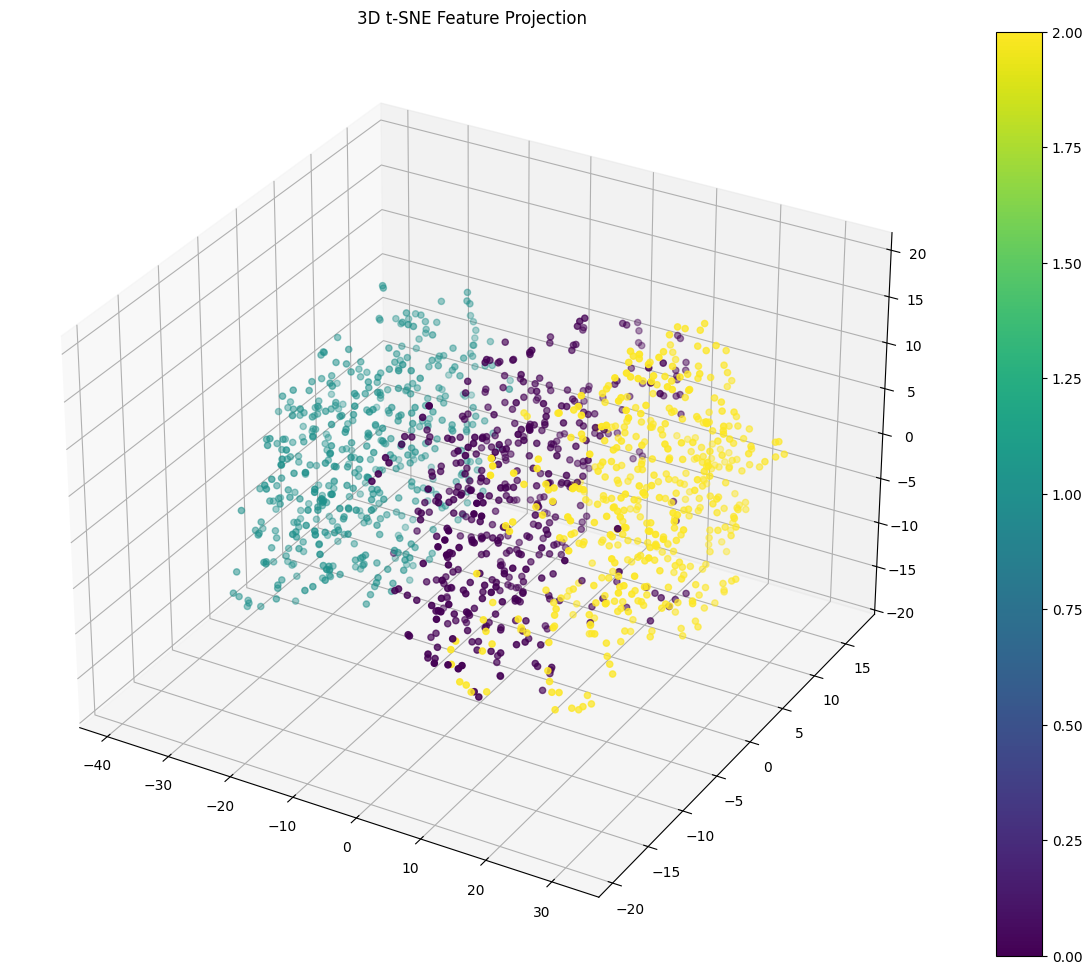

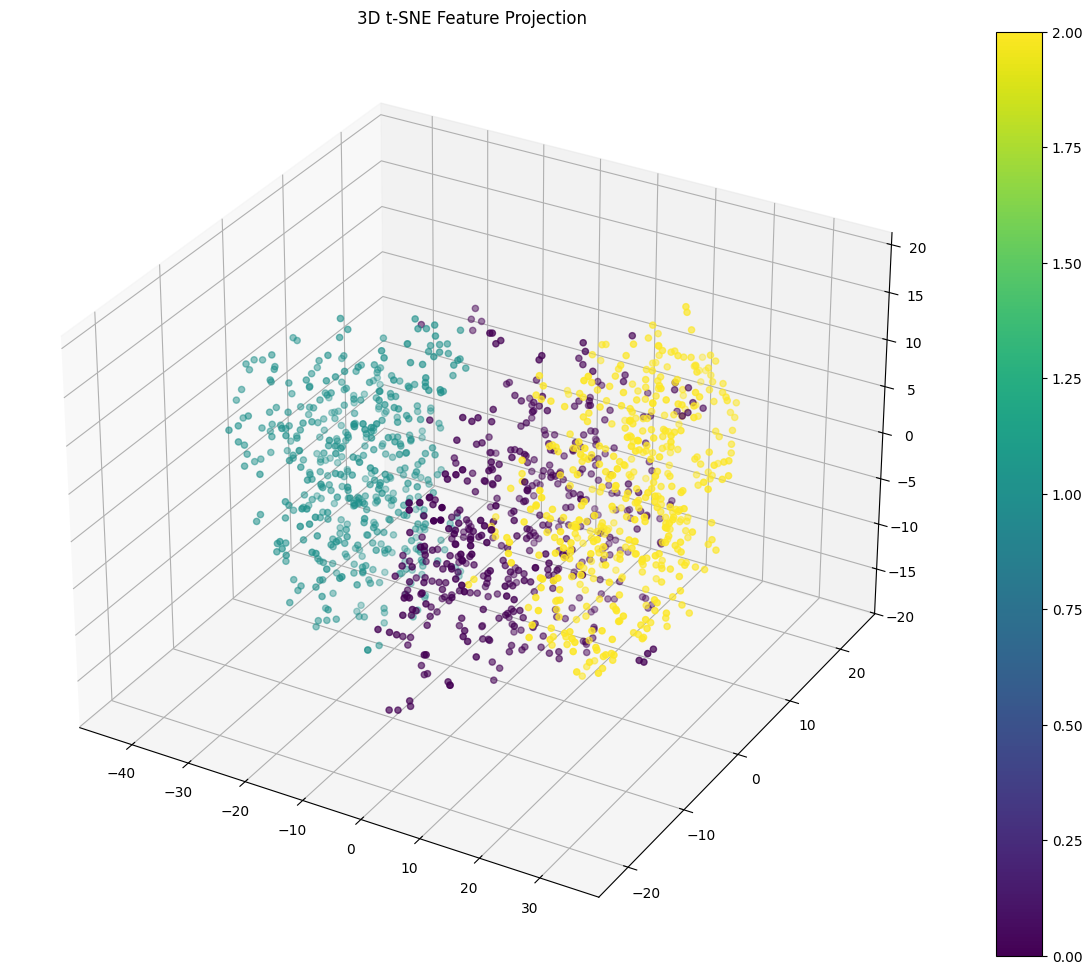

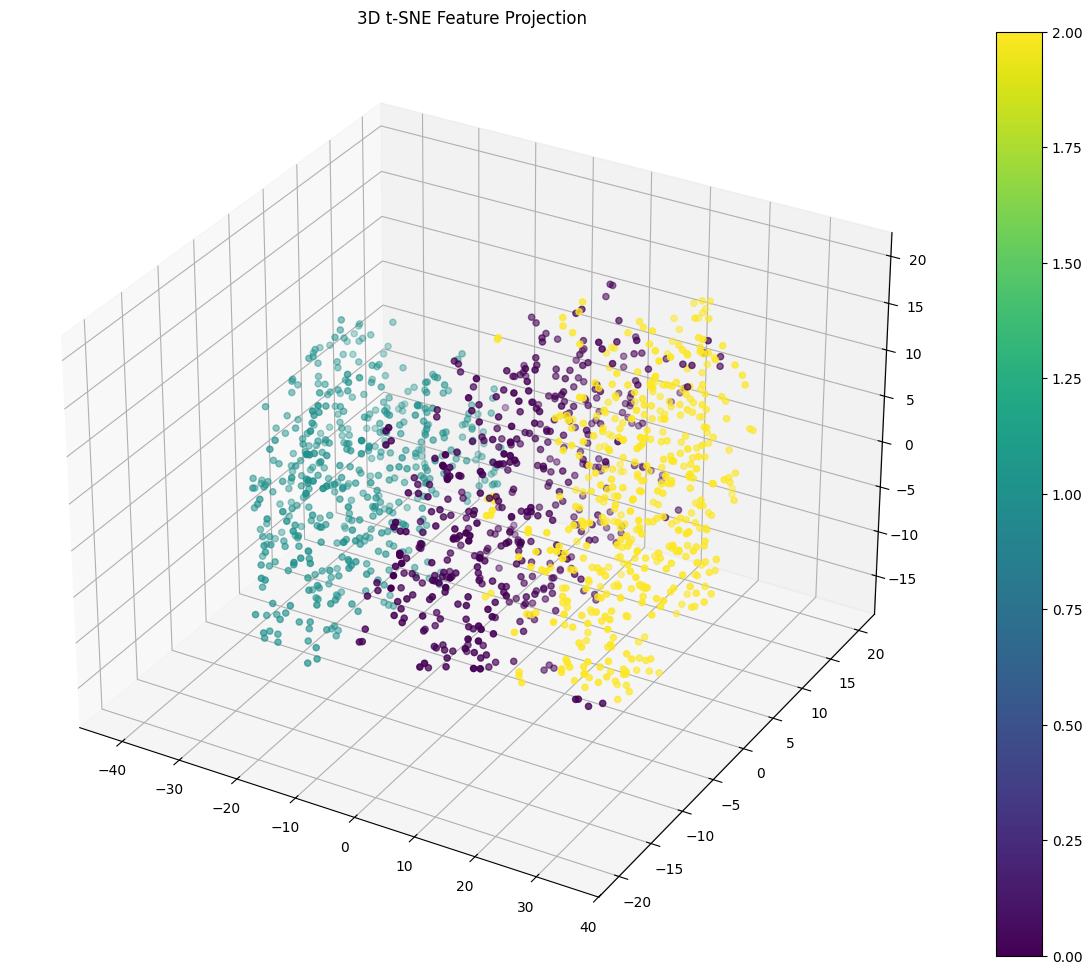

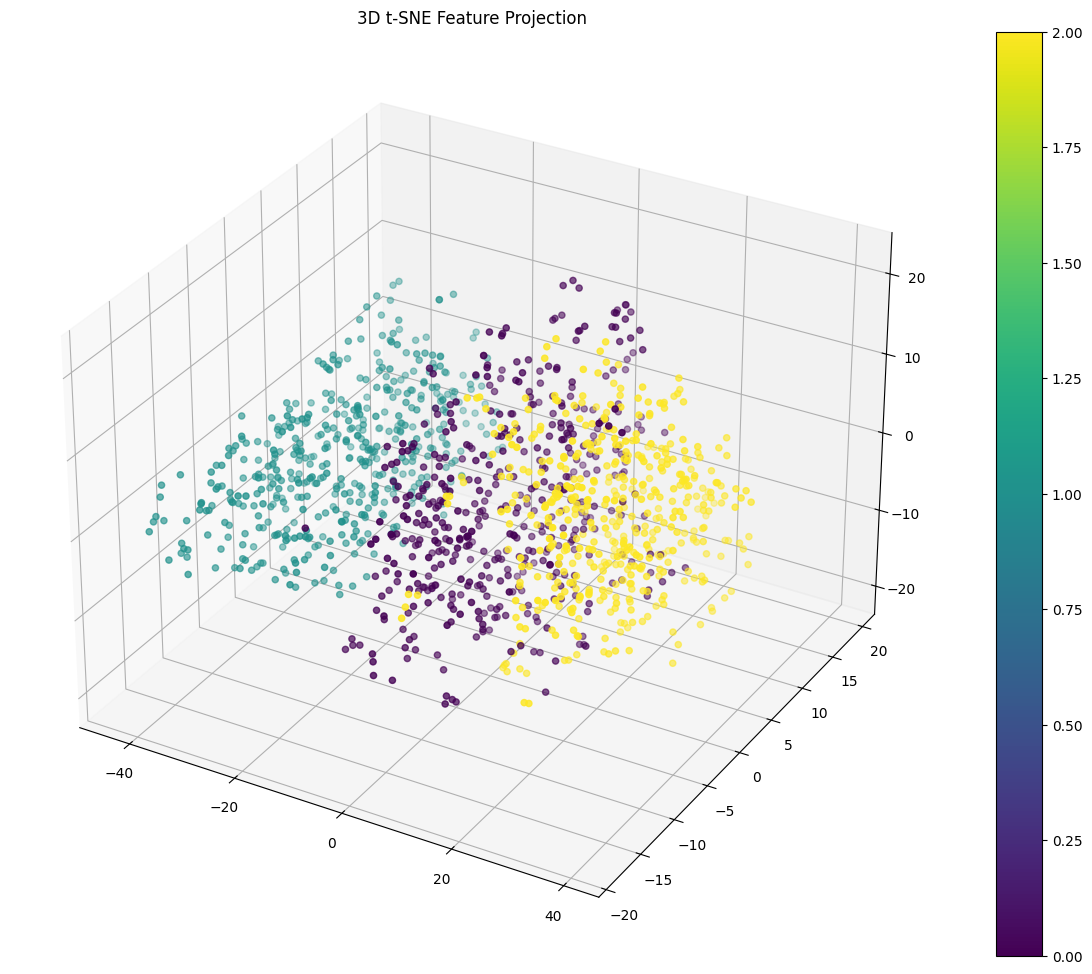

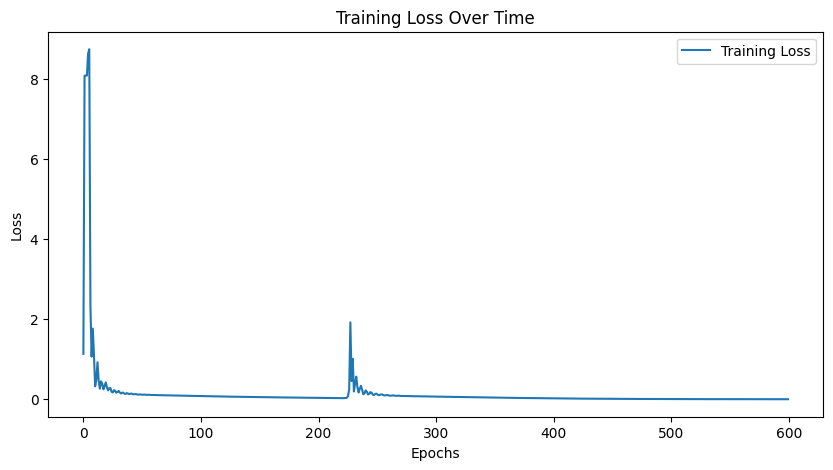

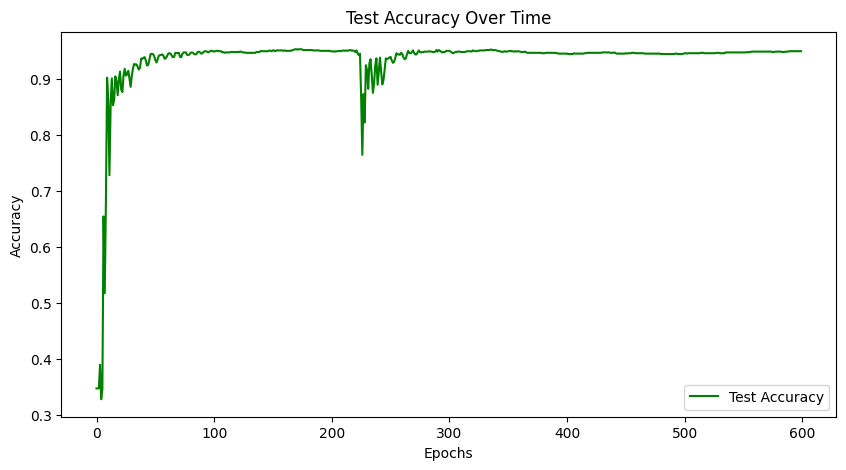

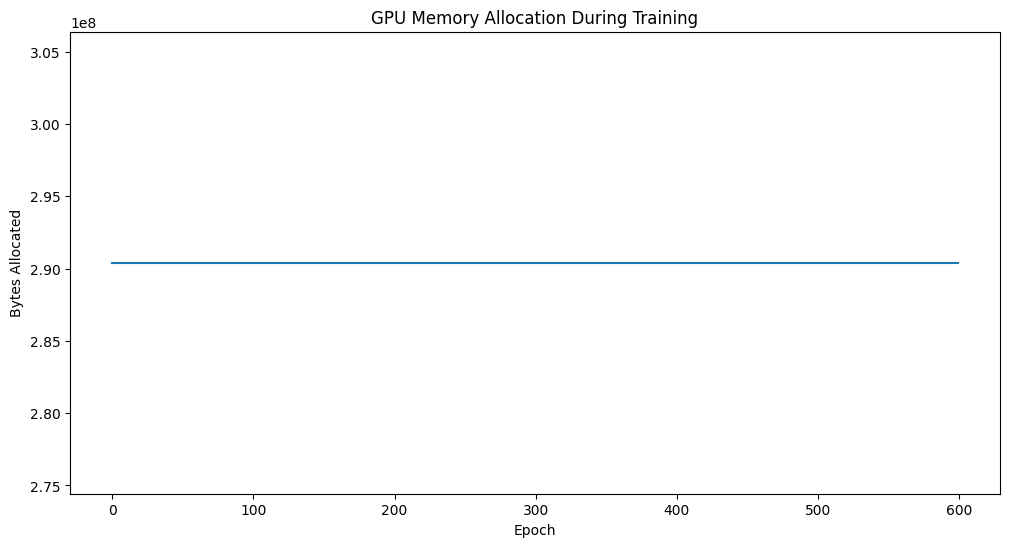

In [ ]:
if __name__ == "__main__":
    # Automatic mixed precision training
    model = GATClassifier(512, 64, len(torch.unique(train_labels))).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses=[]
    test_accuracies=[]
    # Memory monitoring
    memory_log = []
    for epoch in range(600):
        loss = train()
        train_losses.append(loss)
        acc, _ = test(test_data)
        test_accuracies.append(acc)
        memory_log.append(cuda.memory_allocated())
        
        if epoch % 50 == 0:
            with torch.no_grad():
                plot_3d_feature_space(test_features, test_labels).savefig(f'tsne_3d_{epoch}.png')

    plot_training_loss(train_losses)
    plot_accuracy(test_accuracies)
    plt.savefig("training_vs_loss.png")
    plt.figure(figsize=(12, 6))
    plt.plot(memory_log)
    plt.title('GPU Memory Allocation During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Bytes Allocated')
    plt.savefig('training_memory_profile.png')